In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import seaborn as sns

# Carica il dataset
dataset = pd.read_csv(r"dataset.csv")

# Splitta il dataset per Business Tendency Indicator (Cost)
df = dataset[dataset['indic_bt'] == 'COST']

# Elimina le colonne specificate
df = df.drop(columns=['DATAFLOW', 'LAST UPDATE', 's_adj', 'freq', 'cpa2_1', 'CONF_STATUS'])

# Filtra le righe dove OBS_FLAG è vuoto (rimuove righe con flag)
df=df.drop(columns=['OBS_FLAG'])

df = df.fillna(dataset.mean(numeric_only=True))

print(df)

     indic_bt    unit geo  TIME_PERIOD  OBS_VALUE
0        COST     I15  AL         2002       86.2
1        COST     I15  AL         2003       88.6
2        COST     I15  AL         2004       91.3
3        COST     I15  AL         2005       92.5
4        COST     I15  AL         2006       93.5
...       ...     ...  ..          ...        ...
2242     COST  PCH_SM  TR         2023       64.0
2243     COST  PCH_SM  TR         2024       52.8
2244     COST  PCH_SM  UA         2022       27.8
2245     COST  PCH_SM  UA         2023       16.3
2246     COST  PCH_SM  UA         2024        8.7

[2247 rows x 5 columns]


In [2]:
# Crea la colonna 'serie' solo con 'geo' (dato che cpa2_1 è eliminata)
df['serie'] = df['geo']

# Crea la tabella pivot
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='serie', values='OBS_VALUE')

print(pivot_df)

serie               AL         AT          BG         CY         CZ  \
TIME_PERIOD                                                           
1980               NaN        NaN         NaN        NaN        NaN   
1981               NaN        NaN         NaN        NaN        NaN   
1982               NaN        NaN         NaN        NaN        NaN   
1983               NaN        NaN         NaN        NaN        NaN   
1984               NaN        NaN         NaN        NaN        NaN   
1985               NaN        NaN         NaN        NaN        NaN   
1986               NaN        NaN         NaN        NaN        NaN   
1987               NaN        NaN         NaN        NaN        NaN   
1988               NaN        NaN         NaN        NaN        NaN   
1989               NaN        NaN         NaN        NaN        NaN   
1990               NaN  44.900000         NaN        NaN        NaN   
1991               NaN  32.733333         NaN        NaN        NaN   
1992  

In [3]:
## 1. Trasposizione
data = pivot_df.T

# 2. Rimuove righe completamente vuote
data = data.dropna(how='all')

# 3. Imputazione: riempi i NaN con la media di ogni riga
data_filled = data.apply(lambda row: row.fillna(row.mean()), axis=1)

# 4. Rimuovi righe che ancora hanno tutti NaN (es. Media era NaN)
data_filled = data_filled.dropna()

# 5. Controlla che siano rimaste almeno 2 righe
if data_filled.shape[0] < 2:
    print("Errore: troppo poche righe per il clustering.")
else:
    # 6. Standardizzazione
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_filled)

    # 7. Clustering con silhouette
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    best_k = 10
    best_score = -1

    for k in range(2, min(11, data_scaled.shape[0] + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data_scaled)
        score = silhouette_score(data_scaled, labels)
        print(f"Silhouette score per k={k}: {score:.3f}")

        if score > best_score:
            best_score = score
            best_k = k

    print(f"\nMiglior numero di cluster: {best_k} con Silhouette Score = {best_score:.3f}")

    # Applica KMeans finale
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)

Silhouette score per k=2: 0.621
Silhouette score per k=3: 0.387
Silhouette score per k=4: 0.435
Silhouette score per k=5: 0.290
Silhouette score per k=6: 0.304
Silhouette score per k=7: 0.291
Silhouette score per k=8: 0.244
Silhouette score per k=9: 0.297
Silhouette score per k=10: 0.271

Miglior numero di cluster: 2 con Silhouette Score = 0.621


In [4]:
# Crea un DataFrame con le serie originali
clustered_df = pd.DataFrame(data_filled)
clustered_df['cluster'] = labels
clustered_df.to_csv("clustered_countries.csv")
print(clustered_df.head())
print(clustered_df.columns)
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i}")
    print(clustered_df[clustered_df['cluster'] == i].index.tolist())

TIME_PERIOD       1980       1981       1982       1983       1984       1985  \
serie                                                                           
AL           65.102174  65.102174  65.102174  65.102174  65.102174  65.102174   
AT           52.690952  52.690952  52.690952  52.690952  52.690952  52.690952   
BG           67.711364  67.711364  67.711364  67.711364  67.711364  67.711364   
CY           59.802469  59.802469  59.802469  59.802469  59.802469  59.802469   
CZ           61.042000  61.042000  61.042000  61.042000  61.042000  61.042000   

TIME_PERIOD       1986       1987       1988       1989  ...       2016  \
serie                                                    ...              
AL           65.102174  65.102174  65.102174  65.102174  ...  65.533333   
AT           52.690952  52.690952  52.690952  52.690952  ...  61.600000   
BG           67.711364  67.711364  67.711364  67.711364  ...  60.200000   
CY           59.802469  59.802469  59.802469  59.802469  

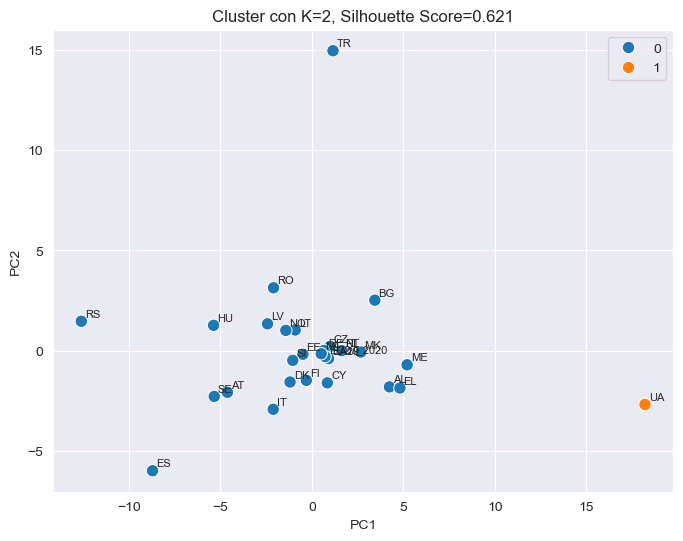

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Riduci a 2 dimensioni per lo scatter plot
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)

# Scatter plot colorato per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=labels, palette='tab10', s=80)
for i, name in enumerate(data_filled.index):
    plt.text(data_2d[i, 0]+0.2, data_2d[i, 1]+0.2, name, fontsize=8)
plt.title("Visualizzazione dei cluster (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.title(f"Cluster con K={best_k}, Silhouette Score={best_score:.3f}")
plt.show()

In [6]:
# Prima, ordina per paese e anno
df = df.sort_values(by=['geo', 'TIME_PERIOD']).reset_index(drop=True)

# Creiamo un DataFrame con costi per paese e anno
# Raggruppiamo per 'geo' e poi applichiamo shift(-1) su OBS_VALUE per avere il valore dell’anno successivo
df['target_cost'] = df.groupby('geo')['OBS_VALUE'].shift(-1)

# Rimuovi righe dove target_cost è NaN (ultimo anno di ciascun paese)
df = df.dropna(subset=['target_cost'])

print(df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'target_cost']].head(10))

  geo  TIME_PERIOD  OBS_VALUE  target_cost
0  AL         2002       86.2         83.2
1  AL         2002       83.2         88.6
2  AL         2003       88.6         85.4
3  AL         2003       85.4          2.6
4  AL         2003        2.6         91.3
5  AL         2004       91.3         88.0
6  AL         2004       88.0          3.0
7  AL         2004        3.0         92.5
8  AL         2005       92.5         89.2
9  AL         2005       89.2          1.4


In [7]:
# Calcola la variazione percentuale anno su anno
df['prev_cost'] = df.groupby('geo')['OBS_VALUE'].shift(1)
df['var_perc'] = (df['OBS_VALUE'] - df['prev_cost']) / df['prev_cost'] * 100.0

# Etichetta le classi
def label_func(x):
    if x > 5:
        return 'aumento'
    elif x < -5:
        return 'diminuzione'
    else:
        return 'stabile'

df['label_variation'] = df['var_perc'].apply(lambda x: label_func(x) if pd.notna(x) else None)

# Rimuovi righe dove prev_cost è NaN (primo anno di ciascun paese)
df = df.dropna(subset=['prev_cost', 'label_variation'])

print(df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'prev_cost', 'var_perc', 'label_variation']].head(10))

   geo  TIME_PERIOD  OBS_VALUE  prev_cost     var_perc label_variation
1   AL         2002       83.2       86.2    -3.480278         stabile
2   AL         2003       88.6       83.2     6.490385         aumento
3   AL         2003       85.4       88.6    -3.611738         stabile
4   AL         2003        2.6       85.4   -96.955504     diminuzione
5   AL         2004       91.3        2.6  3411.538462         aumento
6   AL         2004       88.0       91.3    -3.614458         stabile
7   AL         2004        3.0       88.0   -96.590909     diminuzione
8   AL         2005       92.5        3.0  2983.333333         aumento
9   AL         2005       89.2       92.5    -3.567568         stabile
10  AL         2005        1.4       89.2   -98.430493     diminuzione


In [8]:
# Media mobile su 3 anni (incluso l'anno corrente e i due precedenti)
df['rolling_mean_3'] = df.groupby('geo')['OBS_VALUE'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Deviazione standard su 3 anni
df['rolling_std_3'] = df.groupby('geo')['OBS_VALUE'].transform(lambda x: x.rolling(window=3, min_periods=1).std())

# Dato che il primo anno di ogni paese non ha tre valori precedenti, std sarà NaN => sostituire NaN con 0 o con un valore minimo
df['rolling_std_3'] = df['rolling_std_3'].fillna(0.0)

# Feature binaria se var_perc > 0 (crescita dell’anno precedente)
df['grew_last_year'] = (df['var_perc'] > 0).astype(int)

print(df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'rolling_mean_3', 'rolling_std_3', 'grew_last_year']].head(10))

   geo  TIME_PERIOD  OBS_VALUE  rolling_mean_3  rolling_std_3  grew_last_year
1   AL         2002       83.2       83.200000       0.000000               0
2   AL         2003       88.6       85.900000       3.818377               1
3   AL         2003       85.4       85.733333       2.715388               0
4   AL         2003        2.6       58.866667      48.754624               0
5   AL         2004       91.3       59.766667      49.595598               1
6   AL         2004       88.0       60.633333      50.285419               0
7   AL         2004        3.0       60.766667      50.054604               0
8   AL         2005       92.5       61.166667      50.424035               1
9   AL         2005       89.2       61.566667      50.747052               0
10  AL         2005        1.4       61.033333      51.670333               0


In [9]:
# Definiamo le feature candidate per regressione e classificazione
feature_cols = ['OBS_VALUE', 'rolling_mean_3', 'rolling_std_3', 'grew_last_year']
# Nota: non includere 'TIME_PERIOD' come numero, ma potresti trasformarlo in dummies se vuoi.

# Per regressione:
regression_df = df.dropna(subset=['target_cost']).copy()
X_reg = regression_df[feature_cols]
y_reg = regression_df['target_cost']

# Splitting: usiamo 'TIME_PERIOD' per train/test
train_mask = regression_df['TIME_PERIOD'] <= 2021
X_reg_train = X_reg[train_mask]
X_reg_test = X_reg[~train_mask]
y_reg_train = y_reg[train_mask]
y_reg_test = y_reg[~train_mask]

# Per classificazione:
classification_df = df.dropna(subset=['label_variation']).copy()
X_clf = classification_df[feature_cols]
y_clf = classification_df['label_variation']

# Stesso criterio temporale per la classificazione
train_mask_clf = classification_df['TIME_PERIOD'] <= 2021
X_clf_train = X_clf[train_mask_clf]
X_clf_test = X_clf[~train_mask_clf]
y_clf_train = y_clf[train_mask_clf]
y_clf_test = y_clf[~train_mask_clf]

print("Reg train size:", X_reg_train.shape, "Reg test size:", X_reg_test.shape)
print("Clf train size:", X_clf_train.shape, "Clf test size:", X_clf_test.shape)

Reg train size: (2010, 4) Reg test size: (177, 4)
Clf train size: (2010, 4) Clf test size: (177, 4)


In [10]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Crea e addestra il modello
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_reg_train, y_reg_train)

# 1. Fai le predizioni
y_reg_pred = regressor.predict(X_reg_test)

# 2. Calcola le metriche
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))  # Calcoliamo RMSE manualmente
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"Regressione – RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

Regressione – RMSE: 61.544, MAE: 44.382, R²: 0.253


Distribuzione delle classi nel training set:
label_variation
diminuzione    67.512438
aumento        30.298507
stabile         2.189055
Name: proportion, dtype: float64

Distribuzione delle classi nel test set:
label_variation
diminuzione    51.977401
aumento        46.327684
stabile         1.694915
Name: proportion, dtype: float64
Classification Report:
               precision    recall  f1-score   support

     aumento       1.00      1.00      1.00        82
 diminuzione       0.97      1.00      0.98        92
     stabile       1.00      0.00      0.00         3

    accuracy                           0.98       177
   macro avg       0.99      0.67      0.66       177
weighted avg       0.98      0.98      0.97       177

Confusion Matrix:
 [[82  0  0]
 [ 0 92  0]
 [ 0  3  0]]

Distribuzione originale delle classi: Counter({'diminuzione': 1357, 'aumento': 609, 'stabile': 44})
Distribuzione dopo SMOTE: Counter({'stabile': 1357, 'aumento': 1357, 'diminuzione': 1357})

Report di c

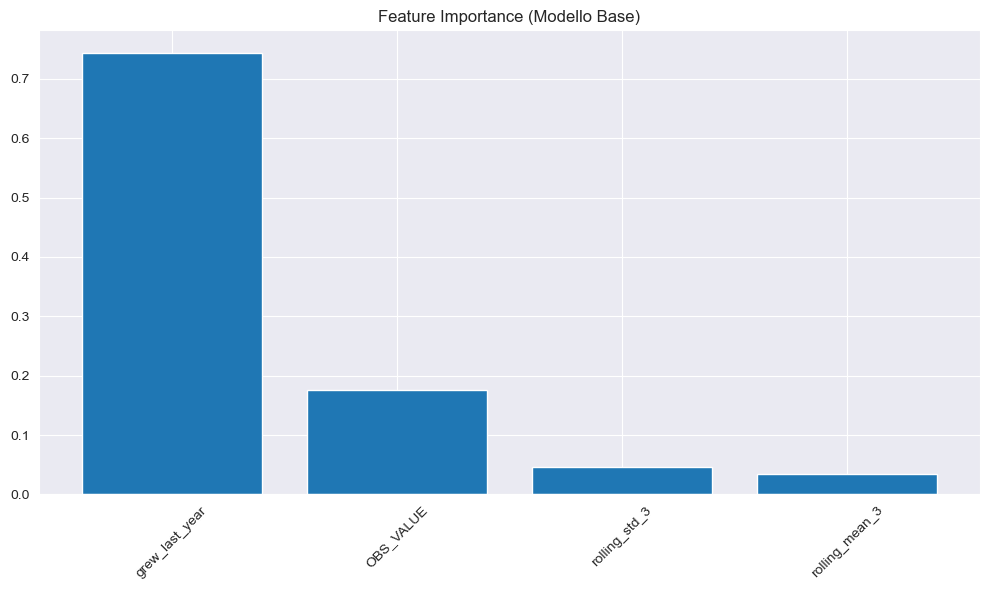

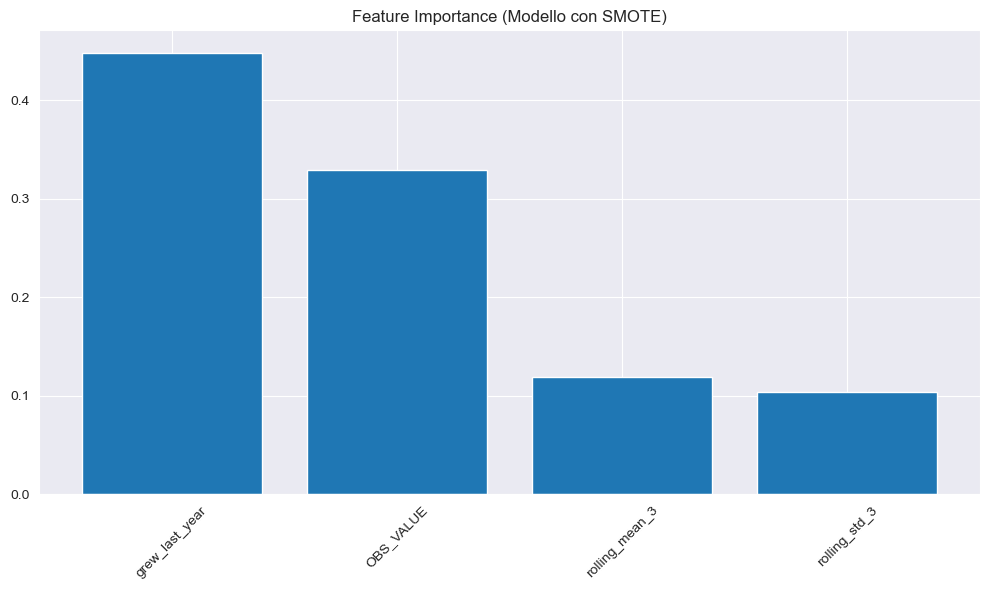

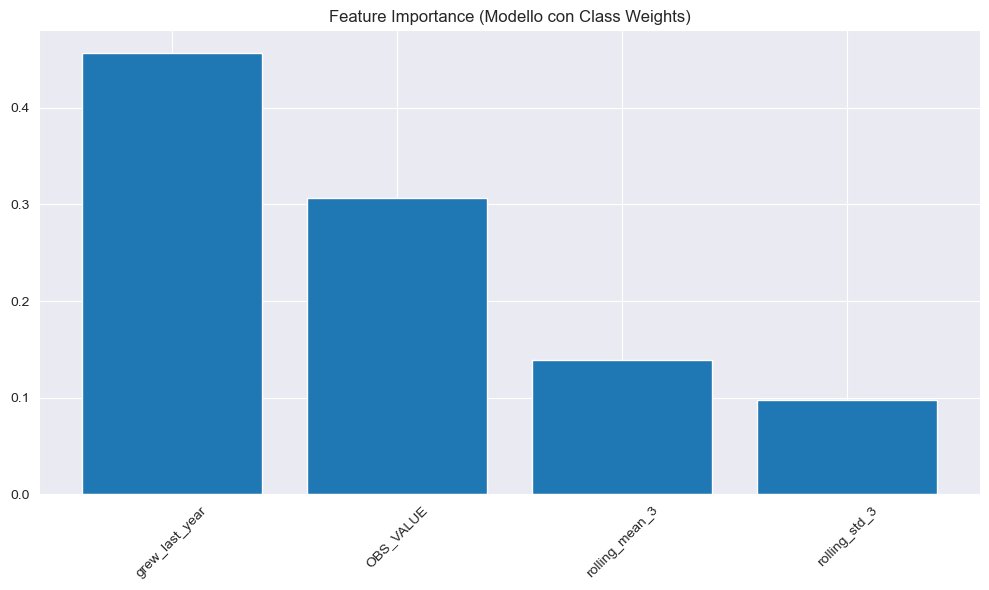

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

# 0. Verifica della distribuzione delle classi
print("Distribuzione delle classi nel training set:")
print(y_clf_train.value_counts(normalize=True) * 100)
print("\nDistribuzione delle classi nel test set:")
print(y_clf_test.value_counts(normalize=True) * 100)

# 1. Crea e addestra il modello
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_clf_train, y_clf_train)

# 2. Predici sui dati di test
y_clf_pred = clf.predict(X_clf_test)

# 3. Calcola le metriche
print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_clf_test, y_clf_pred))

# Applica SMOTE solo al training set
smote = SMOTE(random_state=42)
X_clf_train_balanced, y_clf_train_balanced = smote.fit_resample(X_clf_train, y_clf_train)

print("\nDistribuzione originale delle classi:", Counter(y_clf_train))
print("Distribuzione dopo SMOTE:", Counter(y_clf_train_balanced))

# Addestra il modello con i dati bilanciati
clf_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
clf_balanced.fit(X_clf_train_balanced, y_clf_train_balanced)

# Fai predizioni e valuta
y_clf_pred_balanced = clf_balanced.predict(X_clf_test)
print("\nReport di classificazione con SMOTE:")
print(classification_report(y_clf_test, y_clf_pred_balanced, zero_division=1))

# Calcoliamo i pesi delle classi in modo automatico
from sklearn.utils.class_weight import compute_class_weight

# Calcola i pesi delle classi
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_clf_train),
                                   y=y_clf_train)
class_weight_dict = dict(zip(np.unique(y_clf_train), class_weights))

# Crea e addestra il modello con i pesi delle classi
clf_weighted = RandomForestClassifier(n_estimators=100, 
                                    random_state=42,
                                    class_weight=class_weight_dict)
clf_weighted.fit(X_clf_train, y_clf_train)

# Fai predizioni e valuta
y_clf_pred_weighted = clf_weighted.predict(X_clf_test)
print("\nReport di classificazione con class_weight:")
print(classification_report(y_clf_test, y_clf_pred_weighted, zero_division=1))

# Funzione di valutazione
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nValutazione per {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.3f}")
    print("\nMatrix di confusione:")
    print(confusion_matrix(y_true, y_pred))

# Valutiamo tutti i modelli
evaluate_model(y_clf_test, y_clf_pred, "Modello Base")
evaluate_model(y_clf_test, y_clf_pred_balanced, "Modello con SMOTE")
evaluate_model(y_clf_test, y_clf_pred_weighted, "Modello con Class Weights")

# Visualizziamo le feature importance
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance ({title})")
    plt.bar(range(X_clf_train.shape[1]), importances[indices])
    plt.xticks(range(X_clf_train.shape[1]), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

# Visualizza feature importance per ogni modello
plot_feature_importance(clf, feature_cols, "Modello Base")
plot_feature_importance(clf_balanced, feature_cols, "Modello con SMOTE")
plot_feature_importance(clf_weighted, feature_cols, "Modello con Class Weights")

[PCA] Silhouette score per k=2: 0.787
[PCA] Silhouette score per k=3: 0.462
[PCA] Silhouette score per k=4: 0.504
[PCA] Silhouette score per k=5: 0.419
[PCA] Silhouette score per k=6: 0.414
[PCA] Silhouette score per k=7: 0.387
[PCA] Silhouette score per k=8: 0.394
[PCA] Silhouette score per k=9: 0.383
[PCA] Silhouette score per k=10: 0.394
[PCA] Miglior k: 2 con score 0.787


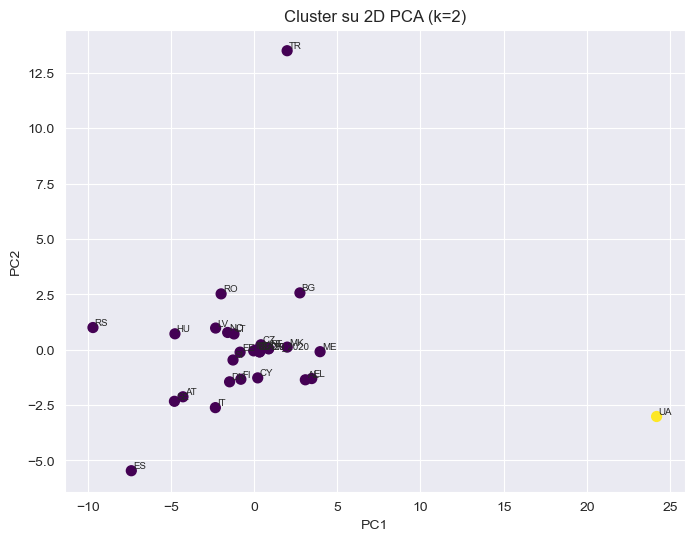

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Partiamo da data_filled (paesi x anni) già calcolato
# -- Ricalcola rapidamente la pipeline per chiarezza:
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE')
data = pivot_df.T.dropna(how='all').apply(lambda row: row.fillna(row.mean()), axis=1)
data_filled = data.dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filled)

# 1. PCA a 2 componenti
pca = PCA(n_components=2, random_state=42)
data_pca2 = pca.fit_transform(data_scaled)

# 2. Clustering con KMeans su dati ridotti
best_k = 2
best_score = -1
for k in range(2, min(11, data_pca2.shape[0] + 1)):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_pca2)
    score = silhouette_score(data_pca2, labels)
    print(f"[PCA] Silhouette score per k={k}: {score:.3f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"[PCA] Miglior k: {best_k} con score {best_score:.3f}")

# Applica KMeans finale su PCA
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_pca = kmeans_final.fit_predict(data_pca2)

# Visualizza i cluster su PCA
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data_pca2[:, 0], data_pca2[:, 1], c=labels_pca, cmap='viridis', s=50)
for i, country in enumerate(data_filled.index):
    plt.text(data_pca2[i, 0]+0.1, data_pca2[i, 1]+0.1, country, fontsize=7)
plt.title(f"Cluster su 2D PCA (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [13]:
from sklearn.cluster import DBSCAN

# Prova DBSCAN su data_scaled (o su data_pca2)
dbscan = DBSCAN(eps=1.0, min_samples=3, metric='euclidean')
labels_db = dbscan.fit_predict(data_scaled)  # o data_pca2

# Calcola silhouette solo per i cluster non -1 (DBSCAN assegna -1 a rumore)
mask = labels_db != -1
if len(set(labels_db[mask])) > 1:
    score_db = silhouette_score(data_scaled[mask], labels_db[mask])
    print(f"Silhouette score DBSCAN (senza rumore): {score_db:.3f}")
else:
    print("DBSCAN ha creato un solo cluster o troppi outlier")

Silhouette score DBSCAN (senza rumore): 0.738


In [14]:
# 1) Esporta dataset pulito con feature e target per regressione e classificazione
df.to_csv("dataset_for_models.csv", index=False)

# 2) Esporta previsioni del modello di regressione (aggiungiamo una colonna con y_reg_pred)
regression_df = regression_df.copy()
regression_df['pred_cost'] = regressor.predict(regression_df[feature_cols])
regression_df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'target_cost', 'pred_cost']].to_csv("regression_results.csv", index=False)

# 3) Esporta etichette di variazione (classification) con probabilità
probs = clf.predict_proba(X_clf_test)
classification_output = classification_df.loc[~train_mask_clf, ['geo', 'TIME_PERIOD', 'OBS_VALUE', 'label_variation']].copy()
# Assumiamo che le classi siano ['aumento','diminuzione','stabile'] nell’ordine di clf.classes_
for idx, cls in enumerate(clf.classes_):
    classification_output[f"prob_{cls}"] = probs[:, idx]
classification_output.to_csv("classification_results.csv", index=False)

print("Dataset pulito con feature e target per regressione e classificazione:")
print(regression_df)

Dataset pulito con feature e target per regressione e classificazione:
     indic_bt    unit geo  TIME_PERIOD  OBS_VALUE serie  target_cost  \
1        COST     I21  AL         2002       83.2    AL         88.6   
2        COST     I15  AL         2003       88.6    AL         85.4   
3        COST     I21  AL         2003       85.4    AL          2.6   
4        COST  PCH_SM  AL         2003        2.6    AL         91.3   
5        COST     I15  AL         2004       91.3    AL         88.0   
...       ...     ...  ..          ...        ...   ...          ...   
2241     COST     I21  UA         2022      127.8    UA         27.8   
2242     COST  PCH_SM  UA         2022       27.8    UA        148.6   
2243     COST     I21  UA         2023      148.6    UA         16.3   
2244     COST  PCH_SM  UA         2023       16.3    UA        161.5   
2245     COST     I21  UA         2024      161.5    UA          8.7   

      prev_cost     var_perc label_variation  rolling_mean_3  ro

In [15]:
print("Dataset con etichette di variazione (classification):")
print(classification_df)

Dataset con etichette di variazione (classification):
     indic_bt    unit geo  TIME_PERIOD  OBS_VALUE serie  target_cost  \
1        COST     I21  AL         2002       83.2    AL         88.6   
2        COST     I15  AL         2003       88.6    AL         85.4   
3        COST     I21  AL         2003       85.4    AL          2.6   
4        COST  PCH_SM  AL         2003        2.6    AL         91.3   
5        COST     I15  AL         2004       91.3    AL         88.0   
...       ...     ...  ..          ...        ...   ...          ...   
2241     COST     I21  UA         2022      127.8    UA         27.8   
2242     COST  PCH_SM  UA         2022       27.8    UA        148.6   
2243     COST     I21  UA         2023      148.6    UA         16.3   
2244     COST  PCH_SM  UA         2023       16.3    UA        161.5   
2245     COST     I21  UA         2024      161.5    UA          8.7   

      prev_cost     var_perc label_variation  rolling_mean_3  rolling_std_3  \
1 

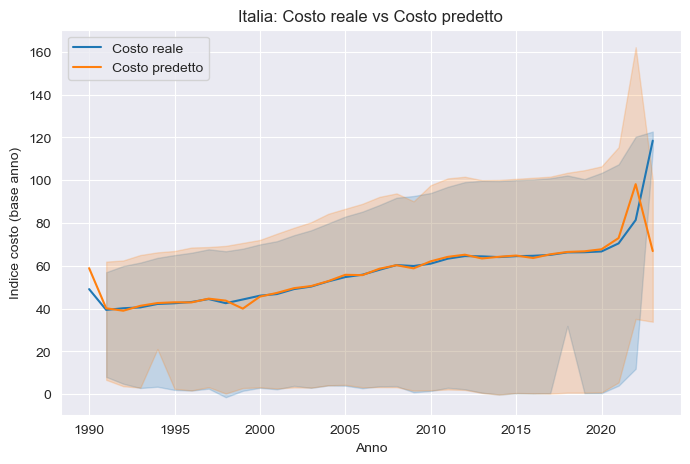

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Esempio: confronto tra COST reale e COST predetto per un dato paese (es. 'IT')
it_df = regression_df[regression_df['geo'] == 'IT']
plt.figure(figsize=(8, 5))
sns.lineplot(x='TIME_PERIOD', y='OBS_VALUE', data=it_df, label='Costo reale')
sns.lineplot(x='TIME_PERIOD', y='pred_cost', data=it_df, label='Costo predetto')
plt.title("Italia: Costo reale vs Costo predetto")
plt.xlabel("Anno")
plt.ylabel("Indice costo (base anno)")
plt.legend()
plt.show()